
# Generate smooth day01_prices_weather.csv

Creates a **single day** (96 × 15‑min) dataset with:
- Outdoor temperature as a smooth sine wave.
- Electricity price with a **duck curve** (morning + evening peaks, cheap mid‑day).

Saves `day01_prices_weather.csv` with columns: `t,dt_h,t_out_c,price_eur_per_kwh`.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
dt_h = 0.25          # hours per step
T = int(24/dt_h)     # steps per day

# Temperature (°C): hot summer day
t_mean = 24.0        # daily average
t_amp = 7.0          # amplitude (night ~17°C, peak ~31°C)
t_warmest_hour = 12  # warmest time of day (~15:00)

# Price (€/kWh) -- duck curve (UNCHANGED)
base_price = 0.16
morning_peak_eur = 0.22
evening_peak_eur = 0.33
midday_valley_eur = 0.08

sigma_morning_h = 1.6
sigma_evening_h = 2.2
sigma_midday_h  = 3.0

# Optional jitter (0 = perfectly smooth)
temp_jitter_std = 0.0
price_jitter_std = 0.0

# Solar generation curve (ideal bell curve peaking at 13:00)
solar_peak_hour = 13.0
solar_sigma_h = 2.5  # Spread of the solar generation
solar_max = 1.0      # Max output (normalized or in kW/kWp)

solar_gen = solar_max * gauss(hours, solar_peak_hour, solar_sigma_h)
df["solar_gen_kw_per_kwp"] = np.round(solar_gen, 3)

# Output path (writes next to this notebook by default)
out_csv = "day01_prices_weather.csv"


In [38]:
# --- Generate ---
t = np.arange(T)
hours = t * dt_h

# Temperature sine wave (summer profile ONLY changed)
t_out = t_mean + t_amp * np.sin(2*np.pi*(hours - t_warmest_hour)/24.0)
if temp_jitter_std > 0:
    t_out = t_out + np.random.default_rng(0).normal(0, temp_jitter_std, size=T)

# Price duck curve: base + morning peak + evening peak - midday valley (UNCHANGED)
def gauss(x, mu, sigma):
    return np.exp(-0.5*((x-mu)/sigma)**2)

price = (base_price
         + morning_peak_eur * gauss(hours, 8.0, sigma_morning_h)
         + evening_peak_eur * gauss(hours, 18.5, sigma_evening_h)
         - midday_valley_eur * gauss(hours, 13.0, sigma_midday_h))

if price_jitter_std > 0:
    price = price + np.random.default_rng(1).normal(0, price_jitter_std, size=T)

price = np.clip(price, 0.05, None)

df = pd.DataFrame({
    "t": t.astype(int),
    "dt_h": np.full(T, dt_h, dtype=float),
    "t_out_c": np.round(t_out, 2),
    "price_eur_per_kwh": np.round(price, 3),
})
df.head()

,t,dt_h,t_out_c,price_eur_per_kwh
0,0,0.25,24.00,0.16
1,1,0.25,23.54,0.16
2,2,0.25,23.09,0.16
3,3,0.25,22.63,0.16
4,4,0.25,22.19,0.16


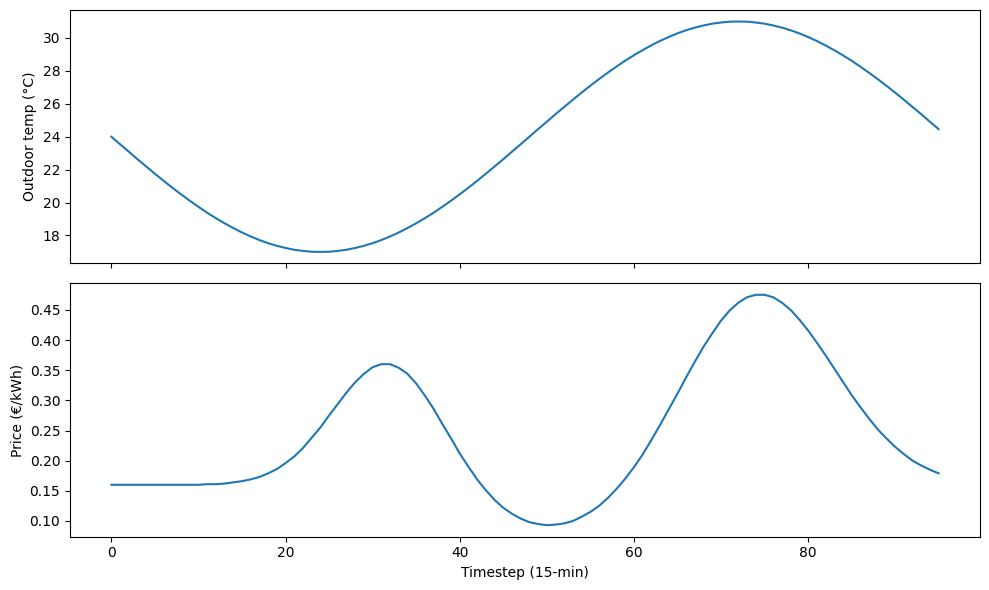

In [39]:

# --- Plot preview ---
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(df["t"], df["t_out_c"])
ax[0].set_ylabel("Outdoor temp (°C)")
ax[1].plot(df["t"], df["price_eur_per_kwh"])
ax[1].set_ylabel("Price (€/kWh)")
ax[1].set_xlabel("Timestep (15-min)")
plt.tight_layout(); plt.show()


In [40]:

# --- Save CSV ---
df.to_csv(out_csv, index=False)
print(f"Saved → {out_csv}  (rows={len(df)})")
df.head(10)


Saved → day01_prices_weather.csv  (rows=96)


,t,dt_h,t_out_c,price_eur_per_kwh
0,0,0.25,24.00,0.16
1,1,0.25,23.54,0.16
2,2,0.25,23.09,0.16
3,3,0.25,22.63,0.16
4,4,0.25,22.19,0.16
5,5,0.25,21.75,0.16
6,6,0.25,21.32,0.16
7,7,0.25,20.90,0.16
8,8,0.25,20.50,0.16
9,9,0.25,20.11,0.16
